# 🐶 End-to-end Multi-class Dog Breed Classification

This notebook builts an end-to-end Multi-class image Classifier using Tensorflow 2.0 and Tensorflow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog , I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed iden. competition.

https://www.kaggle.com/competitions/dog-breed-identification

## 3. Evaluation

The evaluation is a file with prediction prob. for each breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Some info about the data:
* We;re dealing with images (unstructured data) so it's probably best we use deep learning / transfer learning.
* There are 120 breeds of dogs.
* There are around 10000+ images in the training set (with labels)
* There are around 10000+ images in the test set (witouth labels, predicting these)



In [127]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    for gpu in gpus:
        print("Found a gpu with name:", gpu)
else:
    print("Failed to detect a GPU")

Found a gpu with name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [128]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU","available (YESSS!!)" if tf.config.list_physical_devices("GPU") else "not available :(")
print("Num of GPU available: ", len(tf.config.list_physical_devices("GPU")))

TF version: 2.10.1
Hub version: 0.16.1
GPU available (YESSS!!)
Num of GPU available:  1


## Getting our data ready (Turning into tensors)

With all ML models , our data has to be in  numeric format . So that's what we'll be doing firsr . Turning our images into Tensors (numerical representations).repr

Let's start by accessing our data and checking out the labels

In [129]:
labels_csv = pd.read_csv('./data/Dog Vision/dog-breed-identification/labels.csv')

labels_csv.describe()


id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

In [130]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

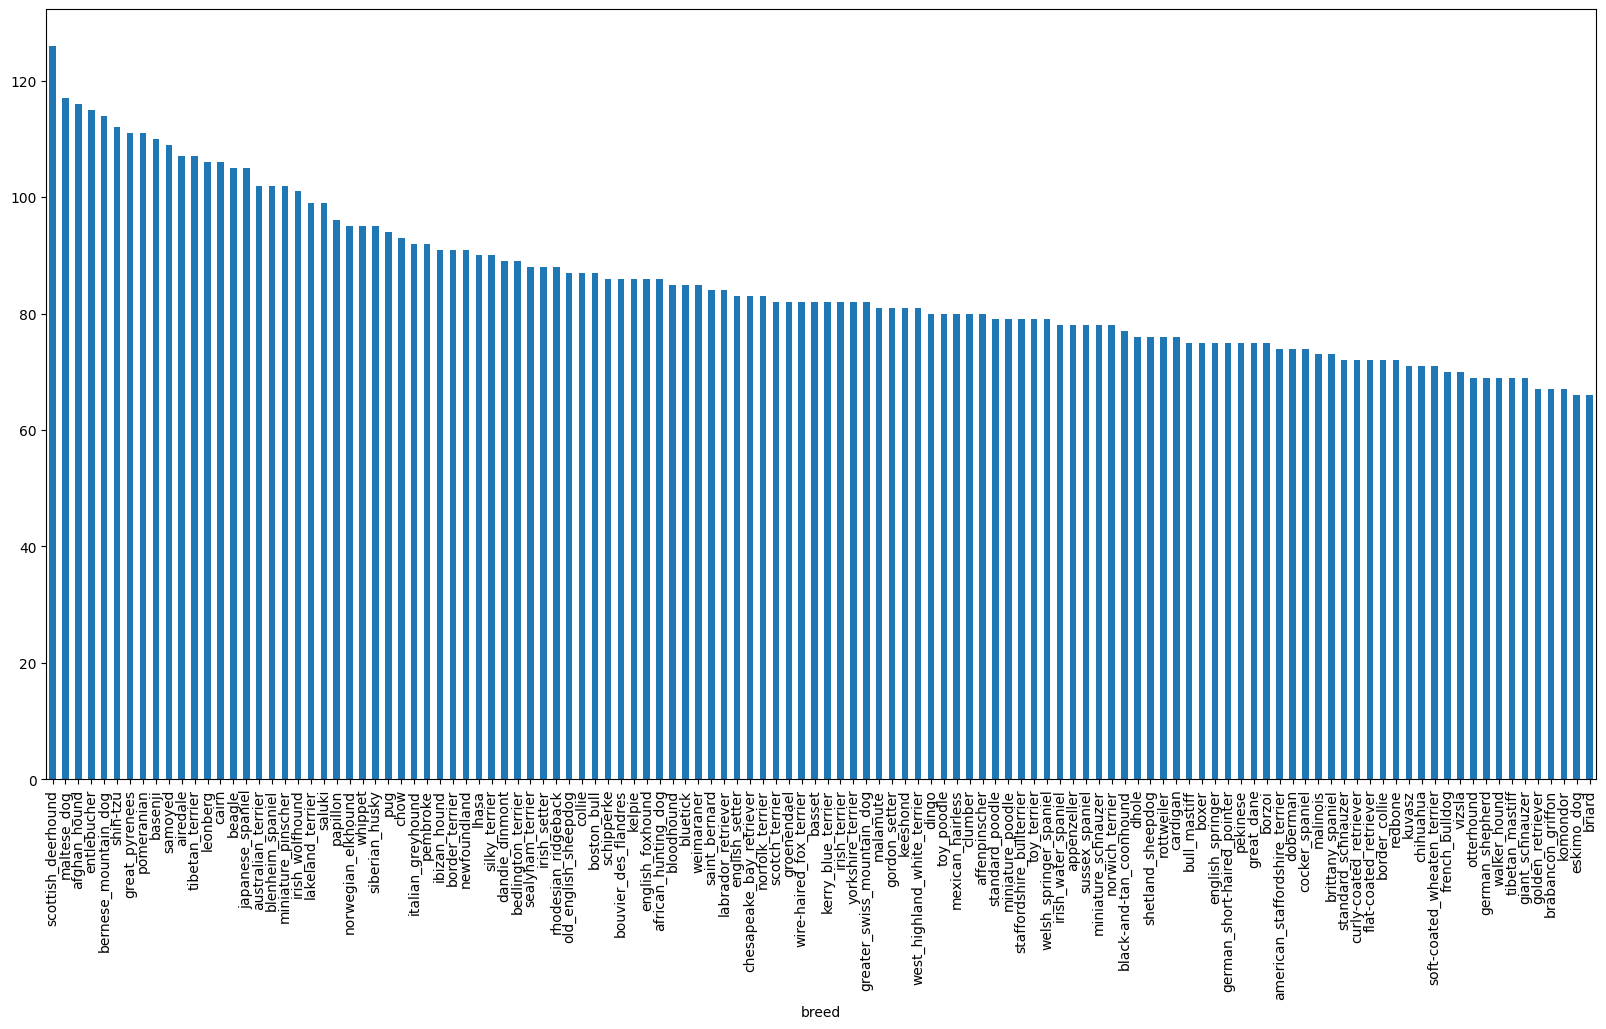

In [131]:
# How many images per breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [132]:
labels_csv["breed"].value_counts().median()

82.0

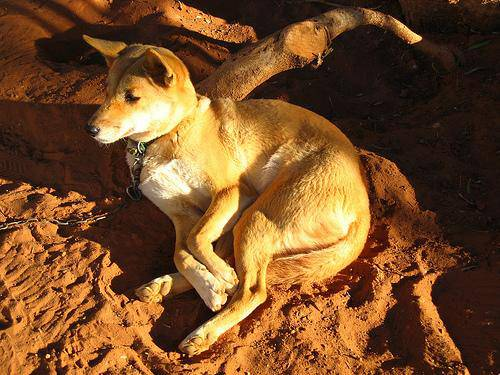

In [133]:
# Let's view an image
from IPython.display import Image
Image("./data/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of our image file pathnames.

In [134]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [135]:
# Create pathnames from imageID'set

filenames = [f'./data/Dog Vision/dog-breed-identification/train/{fname}.jpg' for fname in labels_csv["id"]]

# Check the first 10

filenames[:10]
# len(filenames)


['./data/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 './data/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 './data/Dog Vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 './data/Dog Vision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 './data/Dog Vision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 './data/Dog Vision/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 './data/Dog Vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 './data/Dog Vision/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 './data/Dog Vision/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 './data/Dog Vision/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [136]:
# Check whether no of filenames matches number of actual img files
import os

if len(os.listdir("./data/Dog Vision/dog-breed-identification/train/")) == len(filenames):
    print("Filenames match actual amount of files!!! Proceed")
else:
    print("Filenames do not match actual amount of files!!! check the target directory")


Filenames match actual amount of files!!! Proceed


In [137]:
os.listdir("./data/Dog Vision/dog-breed-identification/train/")[:10]

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '002211c81b498ef88e1b40b9abf84e1d.jpg',
 '00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '002a283a315af96eaea0e28e7163b21b.jpg',
 '003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '0042188c895a2f14ef64a918ed9c7b64.jpg']

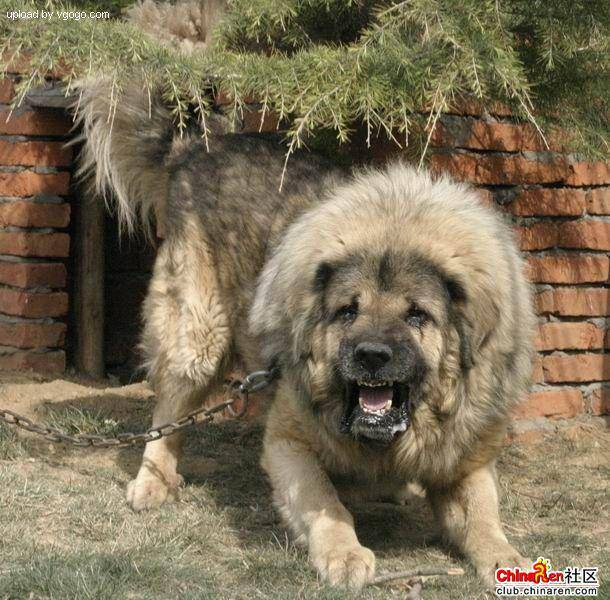

In [138]:
Image(filenames[9000])

In [139]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've got our training image filepaths in a list , let's prepare our labels

In [140]:
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # does the same thing as above
labels


array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [141]:
len(labels)

10222

In [142]:
# See if no of labels matches the no of filenames
if len(labels) == len(filenames):
    print("No of labels matches no of filenames")
else:
    print("No of labels do not match no of filenames, check data dir")

No of labels matches no of filenames


In [143]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds


array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [144]:
len(unique_breeds)

120

In [145]:
# Turn a single label into an array of booleans
labels[0]
labels[0] == unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [146]:
# Turn every label into a boolean array

boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]


[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [147]:
len(boolean_labels)

10222

In [148]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
boolean_labels[0].astype(int) # there will be a 1 where where the sample label occurs

boston_bull
(array([19], dtype=int64),)
19


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [149]:
for label, boolean_label in zip(labels, boolean_labels):
    print(label)
    print(np.where(unique_breeds == label))
    print(boolean_label.argmax())
    print(boolean_label.astype(int))
    

boston_bull
(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
dingo
(array([37], dtype=int64),)
37
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
pekinese
(array([85], dtype=int64),)
85
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
bluetick
(array([15], dtype=int64),)
15
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [150]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [151]:
filenames[:10]

['./data/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 './data/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 './data/Dog Vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 './data/Dog Vision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 './data/Dog Vision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 './data/Dog Vision/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 './data/Dog Vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 './data/Dog Vision/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 './data/Dog Vision/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 './data/Dog Vision/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [152]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [153]:
len(filenames)

10222

We're going to start off exp with ~1000 images and increase as needed


In [154]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

# Set the default value
NUM_IMAGES = 1000

# Define the function to be called when the slider changes
def set_num_images(num_images):
    global NUM_IMAGES
    NUM_IMAGES = num_images
    print("Selected Number of Images:", NUM_IMAGES)

# Create an interactive slider
interact(set_num_images, num_images=widgets.IntSlider(min=1000, max=10000, step=1000, value=NUM_IMAGES))

# Display the current value
print("Initial Number of Images:", NUM_IMAGES)


interactive(children=(IntSlider(value=1000, description='num_images', max=10000, min=1000, step=1000), Output(…

Initial Number of Images: 1000


In [155]:
import sklearn
from sklearn.model_selection import train_test_split

# Split them into training and valid. of total size NUM_IMAGES
X_train , X_val , y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                      y[:NUM_IMAGES],
                                                      test_size=0.2,
                                                      random_state=42)

len(X_train) , len(y_train), len(X_val) , len(y_val)

(800, 800, 200, 200)

In [156]:
# Let's have a geez at the training data

X_train[:5], y_train[:2]


(['./data/Dog Vision/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  './data/Dog Vision/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  './data/Dog Vision/dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  './data/Dog Vision/dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  './data/Dog Vision/dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, Fal

## Preprocessing Images (turning images into Tensors)

To preprocess our images into tensors we're going to write a func which does a few things:

1. Take an img filepath as input.
2. Use `Tensorflow` to read the file and save it to a variable , `image`
3. Turn our `image` (a jpg) into tensors
4. Resize the `image` to be a size of (224,224)
5. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [157]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [158]:
image

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]

In [159]:
image.max() , image.min()

(255, 0)

In [160]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [161]:
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor , let's make a func to preprocess them.

1. Take an img filepath as input.
2. Use `Tensorflow` to read the file and save it to a variable , `image`
3. Turn our `image` (a jpg) into tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be a size of (224,224)
6. Return the modified `image`

 

In [162]:
# Define image size
IMG_SIZE = 224

# Create a function for preproc images

def process_image(image_path, img_size=IMG_SIZE):
    """
    
    Takes an image file path and turns the image into a Tensor.
    
    """
    
    # Read in an image file
    image = tf.io.read_file(image_path)
    
    # Turn the jpg image into num. Tensor with 3 colour channnels (Red, Green , Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Convert color channel values from 0-255 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Resize the `image` to be a size of (224,224)
    image = tf.image.resize(image, size=[img_size, img_size])
    
    return image
    

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively , we need our data in the form of Tensor tuples which look like this:

In [163]:
# Create a simple func to return a tuple (image, label)

def get_image_label(image_path, label):
    
    """
    
    Takes an image file path name and the associated label, preprocess the image and returns a tuple of (image, label).
    
    """
    
    image = process_image(image_path)
    
    return image, label

In [164]:
X[42]

'./data/Dog Vision/dog-breed-identification/train/011e06760794850c40f23d6426c40774.jpg'

In [165]:
y[42]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [166]:
get_image_label(X[42], y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form : `(image, label)` let's make a function to turn all of our data (x & y) into batches

In [167]:
tf.constant(X)

<tf.Tensor: shape=(10222,), dtype=string, numpy=
array([b'./data/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
       b'./data/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
       b'./data/Dog Vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
       ...,
       b'./data/Dog Vision/dog-breed-identification/train/ffe2ca6c940cddfee68fa3cc6c63213f.jpg',
       b'./data/Dog Vision/dog-breed-identification/train/ffe5f6d8e2bff356e9482a80a6e29aac.jpg',
       b'./data/Dog Vision/dog-breed-identification/train/fff43b07992508bc822f33d8ffd902ae.jpg'],
      dtype=object)>

In [168]:
# Define the batch size , 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels)
    
    """
    
    # If the data is a test dataset, we probably don't have labels
    
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    
    # If the data is a valid dataset, we don't need to shuffle it
    
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                  tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    
    else:
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                  tf.constant(y))) # labels
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))
        
        # Create (image, label) tuples (this also turns image path into a preprocessed image)
        data = data.map(get_image_label)
        
        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)
        
        return data_batch

In [169]:
# Create training and validation data batches

train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [170]:
# Checkout the diff attr of our data batches

train_data.element_spec, val_data.element_spec


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches , however, these can be a little hard to understand , let's visualize them!

In [171]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch

def show_25_images(images, labels):
    
    """
    Displays a plot of 25 images and their labels from a data batch.
    
    """
    
    # Setup the figure
    plt.figure(figsize=(10,10))
    
    # Loop through 25 ( for displayong 25 images)
    
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5,5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")
        

In [172]:
unique_breeds[y[0].argmax()]

'boston_bull'

In [173]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

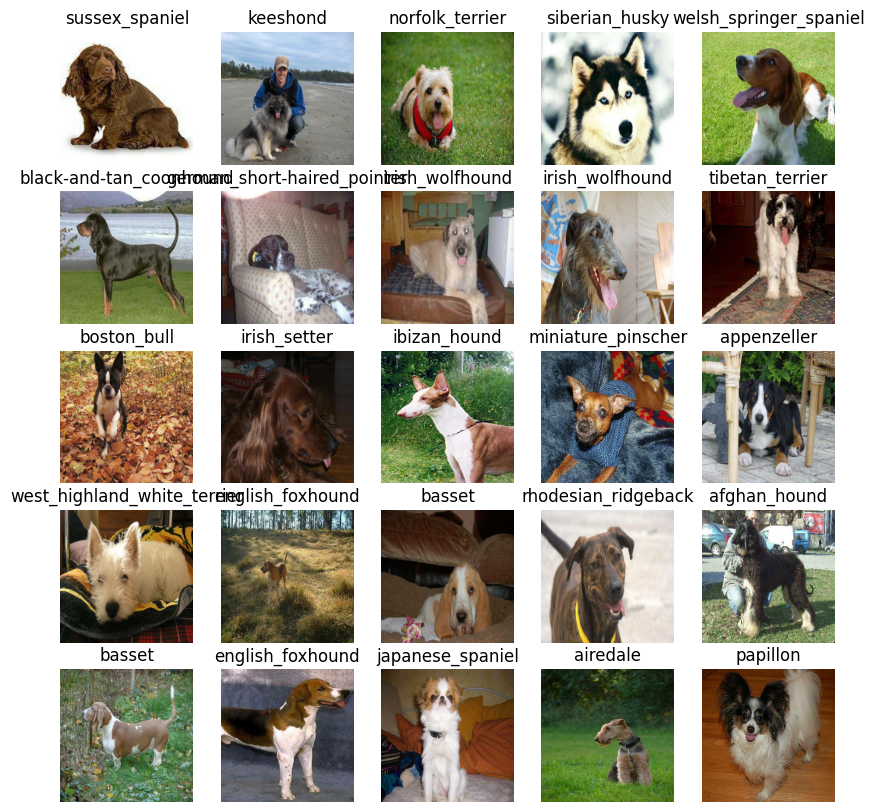

In [174]:
# Now let's visualize the data in a training batch
train_images , train_labels = next(train_data.as_numpy_iterator())

show_25_images(train_images, train_labels)

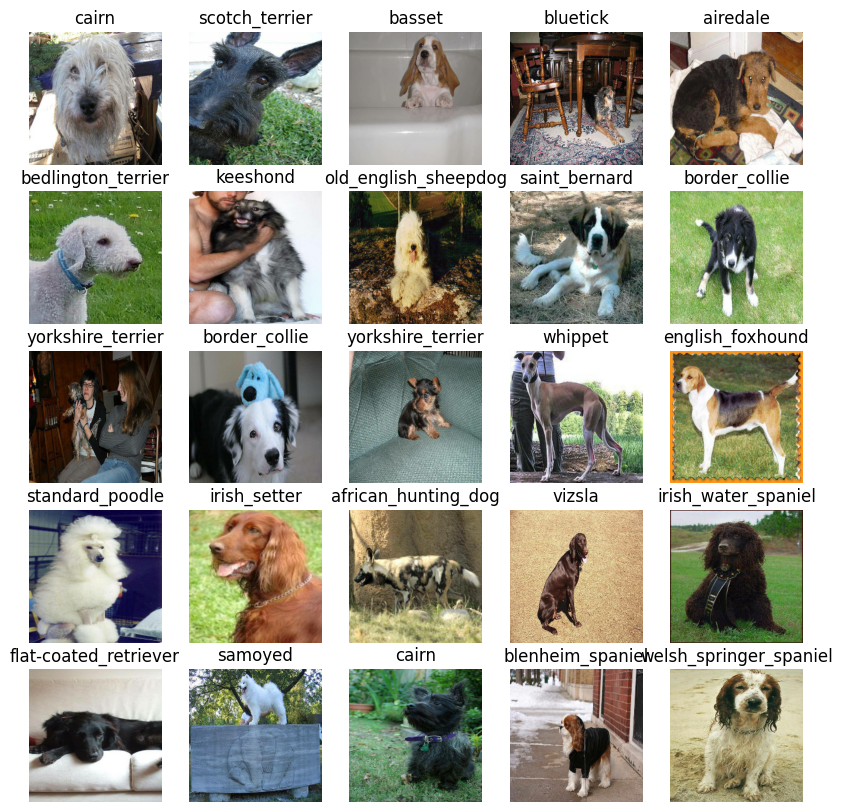

In [175]:
# Now let's visualize the data in a training batch
val_images , val_labels = next(val_data.as_numpy_iterator())

show_25_images(val_images, val_labels)

## Building a model

Before we build a model , there are a few things we need to define:
    
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use

In [176]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch , height, width, colour channels

# Setup output shape to the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TF hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/"
# OUTPUT_SHAPE

Now we've got our inputs, outputs and model ready to go.
Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:

* Takes the input shape , output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that.)
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras

In [177]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)
    
    # Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                              activation="softmax") # Layer 2 (output layer)
    ])
    
    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    
    # Build the model
    model.build(INPUT_SHAPE)
    
    return model

In [178]:
!pip install tensorflow-text

In [179]:
import tensorflow_text

In [180]:
model = create_model()
# checkpoint = tf.train.Checkpoint(model)

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/


In [181]:
outputs = np.ones(shape=(1,1,1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

# Creating callbacks

Callbacks are helper functions a model can use during training to do things as save its progress , check its progress or stop training early if a model stops improving

We'll create 2 calbacks , one for TensorBoard which helps track our model progress and another for early stopping which prevents our model from training for too long.

# TensorBoard Callback

To setup a TensorBoard callback , we need to do 3 things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

In [182]:
# Load TensorBoard notebook extension
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [183]:
import datetime

# Create a fun to build a TB callback
def create_tensorboard_callback():
    # Create log directory for storing TensorBoard logs
    logdir = os.path.join('./data/Dog Vision/dog-breed-identification/logs',
    # Make it so the logs got tracked whenever we run an exp
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metrics stops improving

https://www.tensorflow.org/guide/migrate/early_stopping

In [184]:
# Create early stopping cb

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

# Training a model (on subset of data)

Our first model is going to train 1000 images , to make sure everthing is working.

In [185]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

# Set the default value
NUM_EPOCHS = 100

# Define the function to be called when the slider changes
def set_num_epochs(num_epochs):
    global NUM_EPOCHS
    NUM_EPOCHS = num_epochs
    print("Selected Number of Images:", NUM_EPOCHS)

# Create an interactive slider
interact(set_num_epochs, num_epochs=widgets.IntSlider(min=10, max=100, step=10, value=NUM_EPOCHS))

# Display the current value
print("Initial Number of Epochs:", NUM_EPOCHS)


interactive(children=(IntSlider(value=100, description='num_epochs', min=10, step=10), Output()), _dom_classes…

Initial Number of Epochs: 100


In [186]:
# Check GPU

print("GPU", "available (YESSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU available (YESSS!!!!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it in the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use.
* Return the model

In [187]:
# Build a fn to train and return a trained model
def train_model():
    """
    
    Trains a given model and returns the trained version.
    
    """
    
    # Create a model
    model = create_model()
    
    # Create new TB session everytime we train a model
    
    tensorboard = create_tensorboard_callback()
    
    # Fit the model to the data passing it the cb we created
    
    model.fit(x=train_data, 
              epochs=NUM_EPOCHS,
              validation_data=val_data,
              validation_freq=1,
              callbacks=[tensorboard, early_stopping])
    
    # Return the fitted model
    return model

In [188]:
# Fit the model to the data

model = train_model()


Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/
Epoch 1/100
25/25 [==============================] - 9s 133ms/step - loss: 4.5598 - accuracy: 0.0950 - val_loss: 3.4724 - val_accuracy: 0.2750
Epoch 2/100
25/25 [==============================] - 3s 99ms/step - loss: 1.6258 - accuracy: 0.6888 - val_loss: 2.1355 - val_accuracy: 0.5400
Epoch 3/100
25/25 [==============================] - 2s 97ms/step - loss: 0.5636 - accuracy: 0.9425 - val_loss: 1.6649 - val_accuracy: 0.6050
Epoch 4/100
25/25 [==============================] - 3s 98ms/step - loss: 0.2486 - accuracy: 0.9887 - val_loss: 1.4806 - val_accuracy: 0.6100
Epoch 5/100
25/25 [==============================] - 3s 100ms/step - loss: 0.1447 - accuracy: 0.9962 - val_loss: 1.4003 - val_accuracy: 0.6300
Epoch 6/100
25/25 [==============================] - 3s 101ms/step - loss: 0.1001 - accuracy: 0.9987 - val_loss: 1.3585 - val_accuracy: 0.6450
Epoch 7/100
25/25 [==============================] - 

**Note** : Overfitting ( train acc > val acc )to begin with is a goog thing! It means our model is         learning!!!

### Making and evaluating predictions using a trained model

In [189]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [190]:
# Make pred on the vakidation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 67ms/step


array([[2.4167206e-03, 1.0244917e-04, 1.6753677e-04, ..., 1.4841555e-04,
        1.7817010e-05, 3.4990632e-03],
       [2.4332814e-03, 7.3577504e-04, 6.3903085e-03, ..., 9.0441562e-04,
        5.4433653e-03, 3.4912035e-05],
       [1.2958181e-04, 4.5300086e-04, 4.3778887e-04, ..., 2.5520730e-04,
        7.2960567e-05, 8.4608054e-04],
       ...,
       [2.1439739e-06, 7.5005446e-06, 5.2436826e-05, ..., 1.1164647e-05,
        6.7154283e-06, 6.9988579e-05],
       [4.5621814e-03, 3.0348208e-04, 4.0311821e-05, ..., 6.3074993e-05,
        1.1562012e-04, 4.6359990e-03],
       [2.9619326e-04, 1.7784727e-06, 3.6679569e-04, ..., 1.6963590e-03,
        2.8618550e-04, 2.2582102e-05]], dtype=float32)

In [191]:
np.sum(predictions[0])

1.0

In [192]:
len(predictions[0])

120

In [193]:
np.sum(predictions[0])

1.0

In [194]:
predictions.shape

(200, 120)

In [195]:
len(y_val)

200

In [196]:
len(unique_breeds)

120

In [197]:
# First prediction
index = 143
print(predictions[index])
print(f"Max value (prob of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Prediction label: {unique_breeds[np.argmax(predictions[index])]}")

[2.95552425e-04 2.12340121e-04 4.69230727e-05 4.61752061e-05
 4.59880794e-05 6.68384382e-06 5.62733389e-04 3.83533275e-04
 8.84883455e-04 1.85937085e-03 1.45047822e-03 3.64622319e-05
 2.33262064e-04 1.58927683e-03 7.54439388e-05 2.75952159e-04
 1.18037233e-05 1.04226090e-03 1.38067162e-05 1.07314707e-04
 2.57916254e-04 2.48670869e-04 6.15917224e-06 7.51600874e-06
 6.40919370e-06 7.05278990e-06 7.29019055e-04 1.28747006e-05
 1.56946815e-04 4.98080801e-04 4.02450532e-05 8.68279429e-04
 1.06001867e-03 9.56711847e-06 3.79942299e-04 1.30759971e-02
 3.93579794e-05 1.76938702e-05 8.87990609e-06 1.27209758e-04
 9.48444591e-04 3.02400458e-05 2.36247899e-04 1.36562658e-05
 3.79316152e-05 7.85415832e-05 2.12542218e-05 3.55893026e-05
 2.67067808e-05 6.23830419e-04 8.70047006e-05 2.83553309e-05
 3.59432888e-04 2.18940677e-05 1.20221566e-05 7.31472846e-06
 6.39110585e-05 5.60905202e-04 2.88904441e-04 1.65507925e-04
 2.51911487e-03 4.68991202e-04 1.27268853e-04 8.47143929e-06
 1.51283457e-04 6.387021

In [198]:
unique_breeds[14]

'bloodhound'

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note** : Prediction prob are also known as confidence levels.

In [199]:
# Turn pred prob into their resp label
def get_pred_label(prediction_prob):
    """
    Turns an array of pred prob into a label.
    
    """
    
    return unique_breeds[np.argmax(prediction_prob)]

# Get a pred label based on an array of pred prob

pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

In [200]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Now since our validation data is still in a batch dataset , we'll have to unbatchify it  to make pred on val images and then compare those pred to the val labels(truth labels)

In [201]:
def unbatchify(data):
    images = []
    labels = []
    
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

val_images , val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [202]:
get_pred_label(val_labels[0])
get_pred_label(val_images[0])

'vizsla'

Now we've got ways to get:

* Pred labels
* Val labels
* Validation images

Let's make some functions t make these all a bit more visualize

Now we'll create a function which:
* Takes an array of pred prob , an array of truth labels and an array of images and integers.
* Convert the pred prob to a pred label.
* Plot the pred label , its pred prob , the truth lael and the target image on a single plot.

In [203]:
def plot_pred(prediction_prob, labels, images, n=1):
    '''
    View the pred , ground truth and image for sample n
    
    '''
    
    pred_prob , true_label , image = prediction_prob[n], labels[n], images[n]
    
    # Get the pred label
    pred_label = get_pred_label(pred_prob)
    
    # plot img and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # Chang ethe color  of the title dependign on if the pred i sright/wrong
    
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'
        
    
    # change plot title to be pred , prob of pred and truth label
    plt.title("{} {:2.0f}% {}".format(pred_label, np.max(pred_prob)*100, true_label), color=color)
    
    

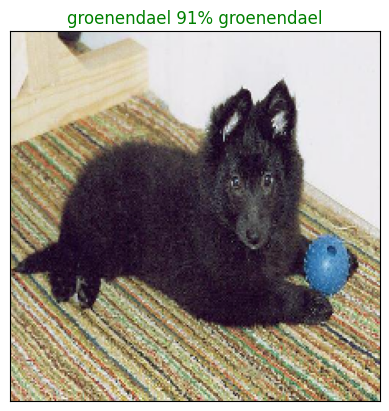

In [204]:
plot_pred(prediction_prob=predictions, labels=val_labels, images=val_images, n=77)

Top 10 pred

In [205]:
def plot_pred_conf(pred_prob, labels, n=1):
    """
    Plus the top 10 highest prediction confidence along with the truth label for sample n.
    
    """
    
    pred_prob , true_label = pred_prob[n] , labels[n]
    
    pred_label = get_pred_label(pred_prob)
    
    # top 10 pred conf index
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # top 10 pred conf values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    
    # top 10 pred labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]
    
    # setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), top_10_pred_values, color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)), labels=top_10_pred_labels, rotation="vertical")
    
    # change the color
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    
    

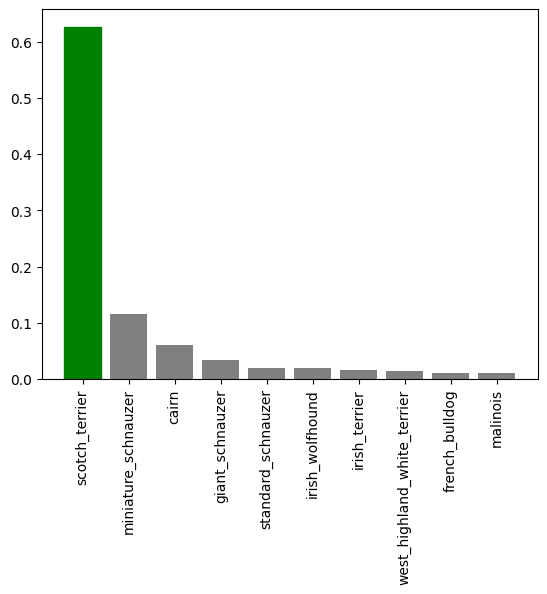

In [206]:
plot_pred_conf(pred_prob=predictions, labels=val_labels)

In [207]:
predictions[0]

array([2.41672061e-03, 1.02449172e-04, 1.67536768e-04, 1.50095093e-05,
       3.15580110e-04, 2.34844956e-05, 1.17220264e-02, 9.11509036e-04,
       8.35944156e-05, 3.86188272e-04, 2.46215321e-04, 1.29734341e-04,
       1.70914136e-04, 2.52368391e-05, 9.67023807e-05, 9.69418557e-04,
       2.10473139e-04, 6.02024011e-02, 2.81772063e-05, 3.38707687e-05,
       2.79805885e-04, 3.05547837e-05, 2.22606013e-05, 8.93828168e-04,
       3.19877763e-05, 2.07711491e-04, 3.21403086e-01, 1.19504119e-04,
       1.24543440e-03, 9.27550791e-05, 1.52290246e-04, 1.91662100e-03,
       4.18667420e-04, 5.26699696e-05, 7.78547474e-05, 1.28594022e-02,
       1.50094802e-05, 9.41959879e-05, 2.05647128e-04, 2.85602910e-05,
       6.40065270e-03, 4.71159437e-05, 5.40601322e-05, 4.66922538e-05,
       1.62122087e-05, 2.08459242e-04, 3.98830780e-05, 1.31349589e-04,
       2.17172375e-04, 1.48508014e-04, 1.93380329e-04, 2.95560531e-05,
       5.56937419e-04, 2.18631267e-05, 3.50213450e-05, 2.42233891e-05,
      

In [208]:
predictions[0][predictions[0].argsort()[-10:][::-1]]

array([0.3214031 , 0.20210867, 0.11709876, 0.07534272, 0.0602024 ,
       0.03713007, 0.01722203, 0.01687238, 0.01631243, 0.01505223],
      dtype=float32)

Now we've got some functions to help us visualize our predictions and evaluate our models , let's check out a few

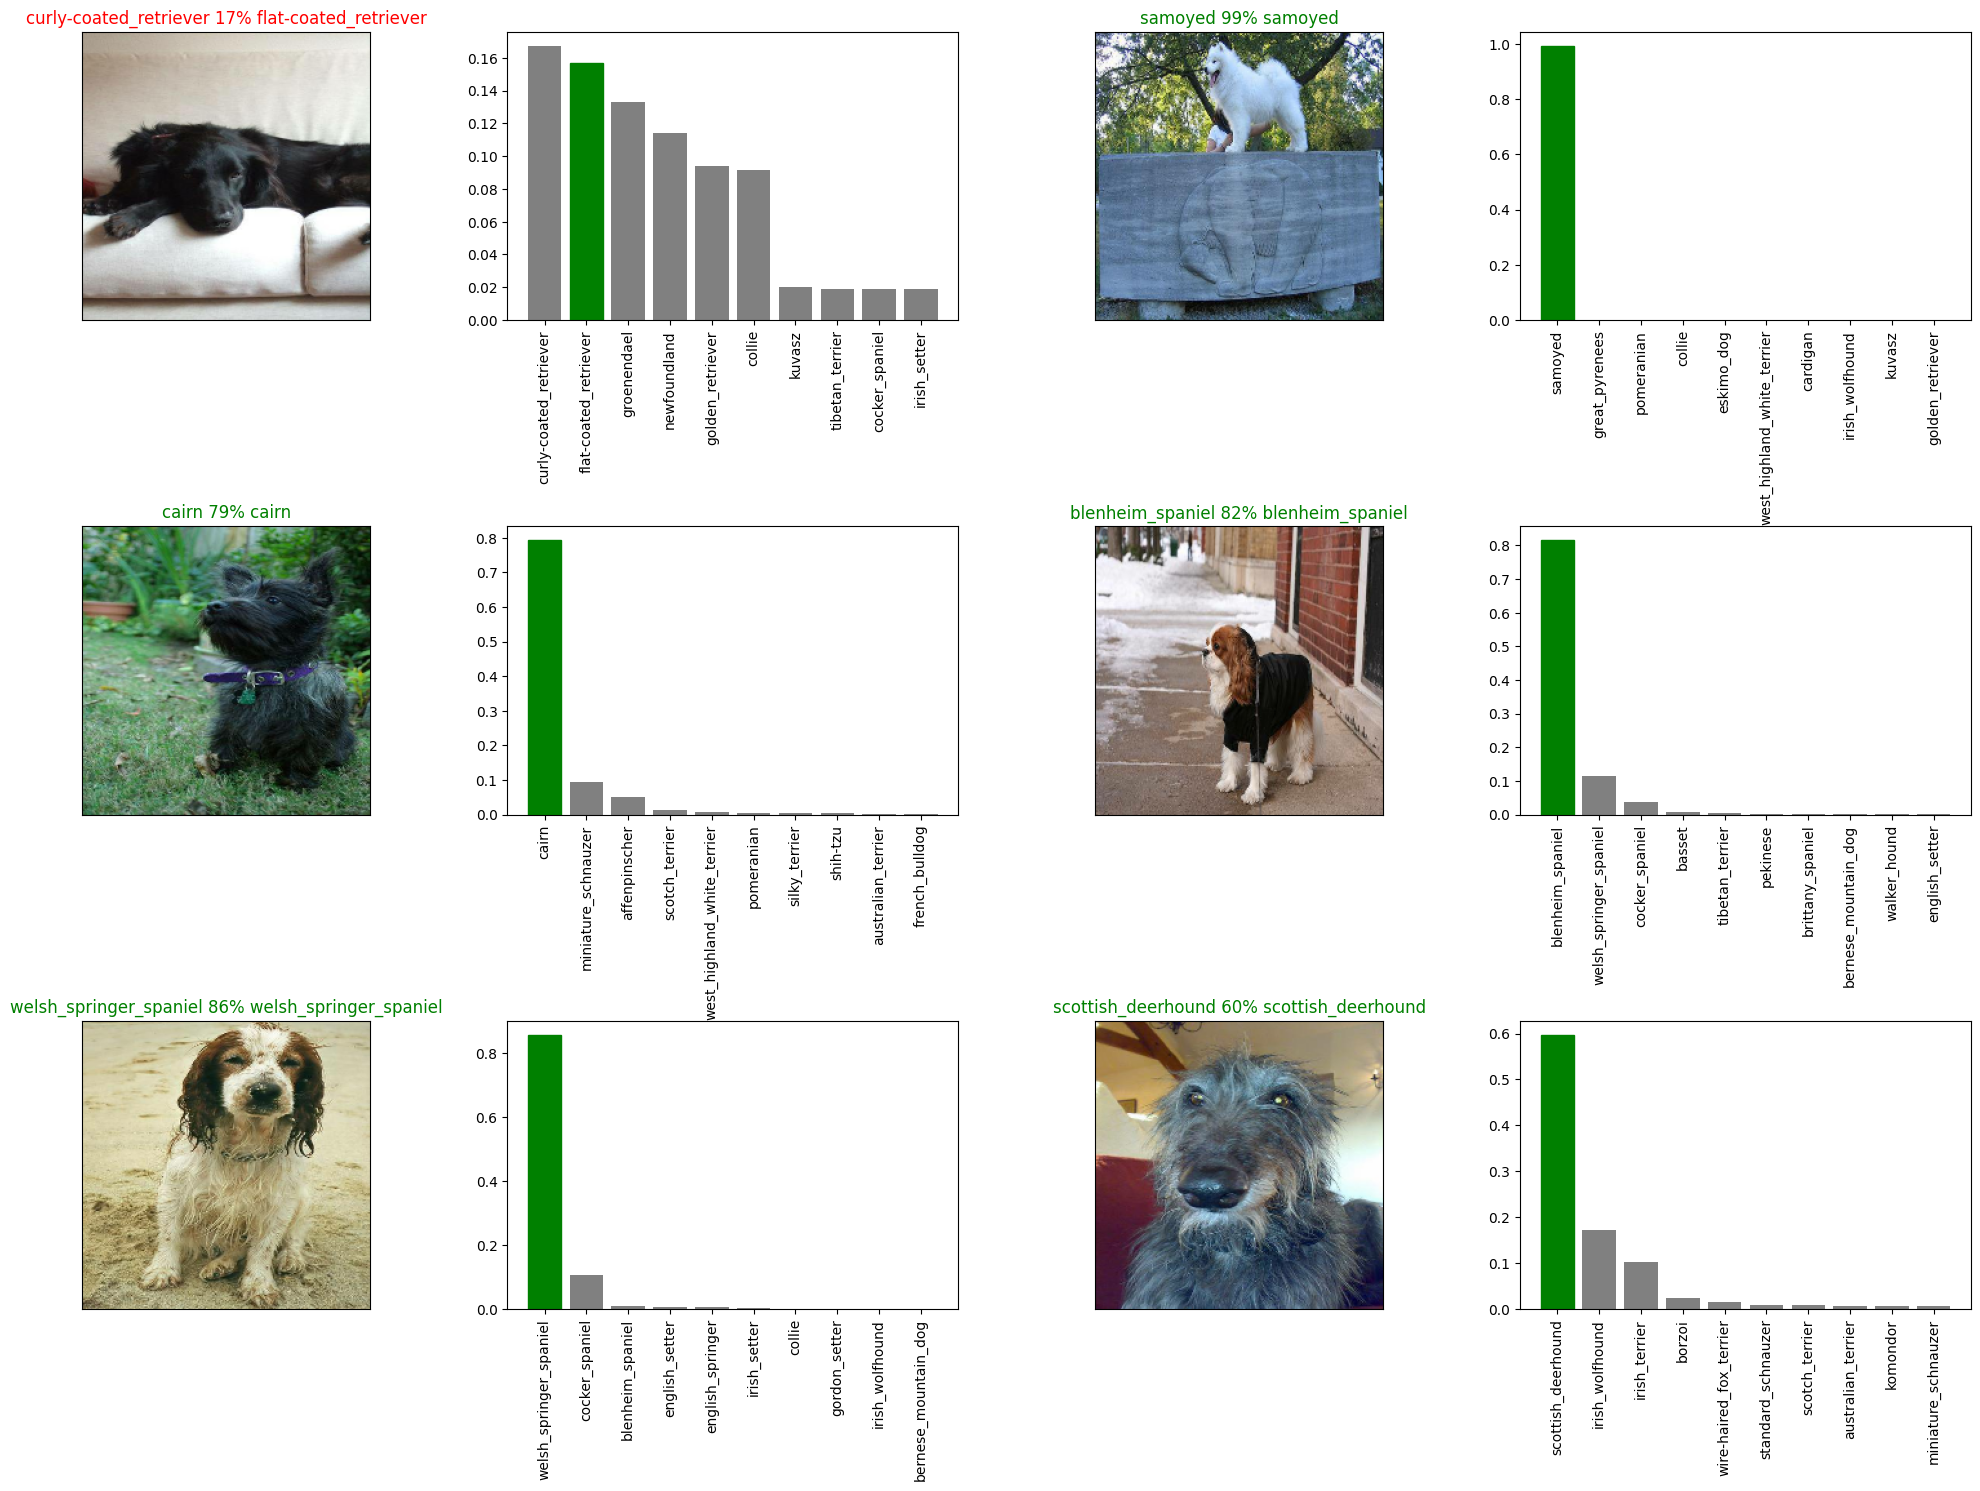

In [209]:
# Let's check out a few and their diff values
i_mult = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_prob=predictions, labels=val_labels, images=val_images, n=i+i_mult)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(pred_prob=predictions, labels=val_labels, n=i+i_mult)
plt.tight_layout(h_pad=0.1)
plt.show()

# Saving and reloading a trained model

In [210]:
# Create a function to save a model

def save_model(model, suffix=None):
    """
    Saves a given model in a models directory ana appends a suffix (string).
    
    """
    
    # Creates a model dir pathname with current time
    
    modeldir = os.path.join("./data/Dog Vision/dog-breed-identification/models", datetime.datetime.now().strftime("%Y%m%d-%H%M"))
    model_path = modeldir + "-" + suffix + ".h5"
    print(f"Saving model to : {model_path}...")
    model.save(model_path)
    return model_path
    
    

In [211]:
def load_model(model_path):
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer": hub.KerasLayer})
    return model

In [212]:
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to : ./data/Dog Vision/dog-breed-identification/models\20240309-1640-1000-images-mobilenetv2-Adam.h5...


'./data/Dog Vision/dog-breed-identification/models\\20240309-1640-1000-images-mobilenetv2-Adam.h5'

In [213]:
loaded_1000_image_model = load_model('./data/Dog Vision/dog-breed-identification/models\\20240304-1655-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: ./data/Dog Vision/dog-breed-identification/models\20240304-1655-1000-images-mobilenetv2-Adam.h5


In [214]:
# Evaluate a pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 66ms/step - loss: 1.2245 - accuracy: 0.6800


[1.2244541645050049, 0.6800000071525574]

In [215]:
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 66ms/step - loss: 1.2577 - accuracy: 0.6700


[1.25770103931427, 0.6700000166893005]

## Training a big dog model (on the full data)

In [216]:
len(X), len(y)

(10222, 10222)

In [217]:
X[:10]

['./data/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 './data/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 './data/Dog Vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 './data/Dog Vision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 './data/Dog Vision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 './data/Dog Vision/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 './data/Dog Vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 './data/Dog Vision/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 './data/Dog Vision/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 './data/Dog Vision/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [218]:
len(X_train)

800

In [219]:
y[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [220]:
# Create a data batch with the full data set

full_data = create_data_batches(X,y)

Creating training data batches...


In [221]:
full_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [222]:
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/


In [223]:
full_model

In [224]:
# Create full model cb
full_model_tensorboard = create_tensorboard_callback()
# NI=o validation set when training on all the data, so we can't monitor valid. acc
full_model_ear_stopp = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

In [225]:
full_model.fit(x=full_data, epochs=NUM_EPOCHS, callbacks=
               [full_model_tensorboard, full_model_ear_stopp])


Epoch 1/100


320/320 [==============================] - 29s 77ms/step - loss: 1.3069 - accuracy: 0.6744
Epoch 2/100
320/320 [==============================] - 25s 76ms/step - loss: 0.4021 - accuracy: 0.8800
Epoch 3/100
320/320 [==============================] - 25s 77ms/step - loss: 0.2312 - accuracy: 0.9372
Epoch 4/100
320/320 [==============================] - 25s 78ms/step - loss: 0.1533 - accuracy: 0.9630
Epoch 5/100
320/320 [==============================] - 25s 78ms/step - loss: 0.1070 - accuracy: 0.9772
Epoch 6/100
320/320 [==============================] - 25s 78ms/step - loss: 0.0758 - accuracy: 0.9868
Epoch 7/100
320/320 [==============================] - 25s 78ms/step - loss: 0.0577 - accuracy: 0.9926
Epoch 8/100
320/320 [==============================] - 25s 78ms/step - loss: 0.0460 - accuracy: 0.9943
Epoch 9/100
320/320 [==============================] - 25s 78ms/step - loss: 0.0370 - accuracy: 0.9966
Epoch 10/100
320/320 [==============================] - 25s 78ms/step - loss: 0.0322 

In [226]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to : ./data/Dog Vision/dog-breed-identification/models\20240309-1647-full-image-set-mobilenetv2-Adam.h5...


'./data/Dog Vision/dog-breed-identification/models\\20240309-1647-full-image-set-mobilenetv2-Adam.h5'

In [228]:
loaded_full_model = load_model('data/Dog Vision/dog-breed-identification/models\\20240309-1647-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: data/Dog Vision/dog-breed-identification/models\20240309-1647-full-image-set-mobilenetv2-Adam.h5


## Making pred on the test data

Since our modek has been trained on images in the form of Tensor batches , to make predictions on the test data , we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches .

To make pred on test data , we'll:
* Get the test image filenames.
* Conv the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels)
* Make a pred array by passing the test batches to the `predict()` method called on our model.

In [239]:
# Load test image filenames

test_path = "data/Dog Vision/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['data/Dog Vision/dog-breed-identification/test/000621fb3cbb32d8935728e48679680e.jpg',
 'data/Dog Vision/dog-breed-identification/test/00102ee9d8eb90812350685311fe5890.jpg',
 'data/Dog Vision/dog-breed-identification/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'data/Dog Vision/dog-breed-identification/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'data/Dog Vision/dog-breed-identification/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'data/Dog Vision/dog-breed-identification/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'data/Dog Vision/dog-breed-identification/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'data/Dog Vision/dog-breed-identification/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'data/Dog Vision/dog-breed-identification/test/002f80396f1e3db687c5932d7978b196.jpg',
 'data/Dog Vision/dog-breed-identification/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [240]:
len(test_filenames)

10357

In [241]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [242]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [243]:
loaded_full_model

In [245]:
test_predictions = loaded_full_model.predict(test_data, verbose=1)

324/324 [==============================] - 24s 73ms/step


In [246]:
np.savetxt("data/preds_array.csv", test_predictions, delimiter=",")


In [251]:
pd.read_csv("data/preds_array.csv")

3.024155925679394841e-11  1.662850412920136023e-11  \
0                  3.046814e-06              4.711198e-07   
1                  1.449308e-10              1.113009e-06   
2                  6.851955e-07              2.340978e-07   
3                  5.084716e-05              1.090311e-05   
4                  4.239040e-12              3.701191e-01   
...                         ...                       ...   
10351              3.421836e-12              1.599108e-06   
10352              1.983745e-10              4.878549e-12   
10353              9.181007e-10              2.066313e-10   
10354              1.638917e-04              1.260902e-06   
10355              6.472984e-08              6.613263e-07   

       4.446465236480380556e-14  1.801658594449001560e-13  \
0                  1.899975e-08              7.899149e-10   
1                  1.565010e-08              4.000239e-11   
2                  1.258196e-06              1.322917e-06   
3                  6.330952e-09              2.224179e-10   
4                  4.288462e-11              4.837080e-06   
...                         ...                       ...   
10351              1.257916e-11              7.634603e-07   
10352              1.013939e-09              1.282652e-08   
10353              1.447882e-07              3.239867e-13   
10354              5.218194e-08              6.758213e-11   
10355              4.906996e-07              3.187140e-08   

       3.040613550872595106e-13  6.948483888963297161e-12  \
0                  1.838094e-06              1.112161e-08   
1                  1.953370e-10              2.725808e-08   
2                  1.742784e-05              4.288706e-07   
3                  8.269566e-10              1.117235e-11   
4                  2.715148e-09              2.765406e-09   
...                         ...                       ...   
10351              9.753250e-10              6.313459e-09   
10352              9.399006e-12              5.585449e-12   
10353              4.215089e-12              4.798268e-10   
10354              2.018055e-08              9.431901e-12   
10355              5.875664e-10              2.133968e-09   

       1.057950080351251904e-15  1.712100296605290062e-12  \
0                  1.075201e-06              8.110310e-07   
1                  2.855539e-11              1.021677e-11   
2                  6.756785e-11              2.127141e-09   
3                  1.792462e-10              2.559102e-09   
4                  1.032780e-11              1.170889e-06   
...                         ...                       ...   
10351              1.971009e-11              1.451207e-10   
10352              6.490824e-08              4.155068e-13   
10353              5.932650e-09              8.136191e-09   
10354              1.095853e-07              1.260715e-08   
10355              2.035697e-11              1.839615e-11   

       3.909105569625814791e-13  4.831573335861705232e-11  ...  \
0                  1.068170e-08              2.997776e-08  ...   
1                  5.480495e-09              2.989573e-11  ...   
2                  3.300093e-07              6.729959e-10  ...   
3                  2.011361e-09              1.038059e-10  ...   
4                  1.552589e-10              2.923476e-13  ...   
...                         ...                       ...  ...   
10351              4.494469e-09              9.528675e-11  ...   
10352              2.927095e-08              3.528694e-10  ...   
10353              2.058367e-10              7.947613e-12  ...   
10354              1.388550e-07              6.947222e-07  ...   
10355              1.327173e-10              5.059852e-12  ...   

       1.260152680988835261e-12  1.290249645406055246e-13  \
0                  8.700246e-09              2.412741e-07   
1                  1.004996e-11              3.081332e-11   
2                  1.365862e-06              5.298871e-11   
3                  6.538117e-08       

In [248]:
# Load pred from csv file
test_predictions = np.loadtxt("data/preds_array.csv", delimiter=",")

In [249]:
test_predictions[:10]

array([[3.02415593e-11, 1.66285041e-11, 4.44646524e-14, ...,
        4.86951618e-14, 6.93645419e-10, 8.73182845e-11],
       [3.04681407e-06, 4.71119847e-07, 1.89997493e-08, ...,
        3.96558827e-11, 7.47161408e-08, 1.77537729e-09],
       [1.44930803e-10, 1.11300926e-06, 1.56501034e-08, ...,
        1.61012608e-07, 1.24195394e-11, 6.69336669e-11],
       ...,
       [1.65186353e-09, 6.99348010e-11, 7.42475317e-11, ...,
        2.57540755e-12, 3.47002787e-12, 6.43592818e-11],
       [2.80236650e-11, 5.92540905e-10, 6.03122136e-11, ...,
        2.89644021e-07, 6.02501549e-10, 5.92663505e-12],
       [2.80349943e-09, 8.72544398e-11, 2.34474679e-11, ...,
        3.54354892e-13, 2.41924154e-11, 1.13021386e-07]])

In [250]:
test_predictions.shape

(10357, 120)

## Prep test dataset for kaggle subm

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

In [252]:
list(unique_breeds)

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [255]:
# Create a pand df with empty col

pred_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
pred_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [265]:
test_path

'data/Dog Vision/dog-breed-identification/test/'

In [267]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids

['000621fb3cbb32d8935728e48679680e',
 '00102ee9d8eb90812350685311fe5890',
 '0012a730dfa437f5f3613fb75efcd4ce',
 '001510bc8570bbeee98c8d80c8a95ec1',
 '001a5f3114548acdefa3d4da05474c2e',
 '00225dcd3e4d2410dd53239f95c0352f',
 '002c2a3117c2193b4d26400ce431eebd',
 '002c58d413a521ae8d1a5daeb35fc803',
 '002f80396f1e3db687c5932d7978b196',
 '0036c6bcec6031be9e62a257b1c3c442',
 '0041940322116ae58c38130f5a6f71f9',
 '0042d6bf3e5f3700865886db32689436',
 '004476c96f575879af4af471af65cae8',
 '00485d47de966a9437ad3b33ac193b6f',
 '00496f65de6cc319145ce97bd6e90360',
 '004bf14426d1a830d459a9e0c0721309',
 '004c3721eb88358f462cdcec6b2380b7',
 '00559f56aab7e0a7749220f6aed65162',
 '005b281f1a4d6f29d527c9585e9bd33c',
 '005b6c6c76fefd6b458ef6fb6e54da6e',
 '006870b49353779b25eeb91fed43c31a',
 '0068f3a21b159ece126a28580cdad7a0',
 '0069b1cc4546fc98f84f981bf9a0696a',
 '0077bc3c63486ff09d3774d956af8f76',
 '00780e5d2bf4f7e4b5f96d08ddde669a',
 '007ed71136966728f5c0936e23c8286b',
 '0081831ceb49cd64212c32b884036b82',
 

In [264]:
os.path.splitext(test_filenames[0])

('data/Dog Vision/dog-breed-identification/test/000621fb3cbb32d8935728e48679680e',
 '.jpg')

In [268]:
pred_df["id"] = test_ids

In [272]:
len(pred_df)

10357

In [273]:
pred_df.head()

id affenpinscher afghan_hound  \
0  000621fb3cbb32d8935728e48679680e           NaN          NaN   
1  00102ee9d8eb90812350685311fe5890           NaN          NaN   
2  0012a730dfa437f5f3613fb75efcd4ce           NaN          NaN   
3  001510bc8570bbeee98c8d80c8a95ec1           NaN          NaN   
4  001a5f3114548acdefa3d4da05474c2e           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [271]:
test_predictions.shape

(10357, 120)

In [274]:
pred_df[list(unique_breeds)] = test_predictions
pred_df.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e   3.024156e-11  1.662850e-11   
1  00102ee9d8eb90812350685311fe5890   3.046814e-06  4.711198e-07   
2  0012a730dfa437f5f3613fb75efcd4ce   1.449308e-10  1.113009e-06   
3  001510bc8570bbeee98c8d80c8a95ec1   6.851955e-07  2.340978e-07   
4  001a5f3114548acdefa3d4da05474c2e   5.084716e-05  1.090311e-05   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         4.446465e-14  1.801659e-13                    3.040614e-13   
1         1.899975e-08  7.899149e-10                    1.838094e-06   
2         1.565010e-08  4.000239e-11                    1.953370e-10   
3         1.258196e-06  1.322917e-06                    1.742784e-05   
4         6.330952e-09  2.224179e-10                    8.269566e-10   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  6.948484e-12        1.057950e-15  1.712100e-12  3.909106e-13  ...   
1  1.112161e-08        1.075201e-06  8.110310e-07  1.068170e-08  ...   
2  2.725808e-08        2.855539e-11  1.021677e-11  5.480495e-09  ...   
3  4.288706e-07        6.756785e-11  2.127141e-09  3.300093e-07  ...   
4  1.117235e-11        1.792462e-10  2.559102e-09  2.011361e-09  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  1.260153e-12  1.290250e-13  8.908485e-14  2.062330e-15  2.074332e-14   
1  8.700246e-09  2.412741e-07  9.265846e-10  2.841257e-06  4.672336e-08   
2  1.004996e-11  3.081332e-11  1.273316e-07  1.258558e-06  1.457560e-07   
3  1.365862e-06  5.298871e-11  2.296918e-06  9.327669e-10  2.349580e-07   
4  6.538117e-08  5.095351e-11  2.096315e-11  8.616419e-11  3.785130e-10   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            1.369480e-12                 5.151866e-13  4.869516e-14   
1            2.751385e-07                 1.995963e-04  3.965588e-11   
2            1.123720e-07                 3.932357e-12  1.610126e-07   
3            5.140803e-10                 2.795757e-15  2.669951e-03   
4            1.397511e-10                 2.216419e-11  1.071467e-08   

   wire-haired_fox_terrier  yorkshire_terrier  
0             6.936454e-10       8.731828e-11  
1             7.471614e-08       1.775377e-09  
2             1.241954e-11       6.693367e-11  
3             5.120505e-11       3.643588e-07  
4             8.420946e-11       2.556513e-08  

[5 rows x 121 columns]

In [275]:
pred_df.to_csv("data/model_predictions_submission.csv", index=False)

# Making predictions on custom images

To make pred on custom images , we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels , we set the `test_data` parameter to True.
* Pass the custom image data batch to our model's `predict()` method
* Convert the predictions output prob to predictions labels.
* Compare the predictions labels to custom images.

In [278]:
custom_path = "data/Dog Vision/dog-breed-identification/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [279]:
custom_image_paths

['data/Dog Vision/dog-breed-identification/my-dog-photos/dog-2.jpg',
 'data/Dog Vision/dog-breed-identification/my-dog-photos/dog-3.jpg',
 'data/Dog Vision/dog-breed-identification/my-dog-photos/dog1.jpg']

In [280]:
# Turn custom images into data batches
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [281]:
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 598ms/step


In [283]:
custom_preds.shape

(3, 120)

In [284]:
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['vizsla', 'black-and-tan_coonhound', 'labrador_retriever']

In [285]:
custom_images = []


for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

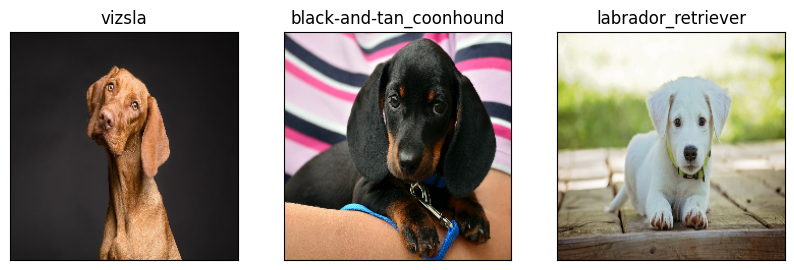

In [286]:
plt.figure(figsize=(10,10))
for i , image in enumerate(custom_images):
    plt.subplot(1, 3, i+1)
    plt.xticks([]),
    plt.yticks([]),
    plt.title(custom_pred_labels[i])
    plt.imshow(image)
    